### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from tqdm import tqdm

### Dataloader

In [3]:
train_path = '/content/drive/MyDrive/Datasets/MNIST/train.csv'
test_path = '/content/drive/MyDrive/Datasets/MNIST/test.csv'

In [4]:
train_df = pd.read_csv(train_path)
print(train_df.shape)

(42000, 785)


In [5]:
from keras.datasets import mnist
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()
train1 = np.concatenate([x_train1, x_test1], axis=0).reshape(-1, 784)
y_train1 = np.concatenate([y_train1, y_test1], axis=0)

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
new_train_df = np.concatenate([y_train1.reshape(-1, 1), train1], axis=1)
new_train_df = pd.DataFrame(new_train_df, index=[str(i) for i in range(42001, 112001)],
                            columns=['label']+['pixel'+str(i) for i in range(784)])
train_df = pd.concat([train_df, new_train_df], axis=0)

In [7]:
X = train_df.loc[:,train_df.columns != "label"].values/255
Y = train_df.label.values
features_train, features_test, targets_train, targets_test = train_test_split(X,Y,test_size=0.2,
                                                                              random_state=42)
X_train = torch.from_numpy(features_train)
X_test = torch.from_numpy(features_test)

Y_train = torch.from_numpy(targets_train).type(torch.LongTensor) 
Y_test = torch.from_numpy(targets_test).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(X_train.view(-1,1,28,28),Y_train)
test = torch.utils.data.TensorDataset(X_test.view(-1,1,28,28),Y_test)


train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle = False)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


### Training & Validation

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, stride=1, padding=0)
        self.cnn_2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride=1, padding=0)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(p=0.2)
        self.dropout2d = nn.Dropout2d(p=0.2)
        
        self.fc1 = nn.Linear(32 * 4 * 4, 128) 
        self.fc2 = nn.Linear(128, 64) 
        self.out = nn.Linear(64, 10) 
        
    def forward(self,x):
        
        out = self.cnn_1(x)
        out = self.relu(out)
        out = self.dropout2d(out)
        out = self.maxpool(out)
        
        out = self.cnn_2(out)
        out = self.relu(out)
        out = self.dropout2d(out)
        out = self.maxpool(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.out(out)
        
        return out

In [ ]:
model = CNN()
model = model.double()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.003)

In [ ]:
epochs = 5
train_losses, test_losses = [] ,[]
for epoch in range(epochs):
    running_loss = 0
    for images,labels in train_loader:
        train = Variable(images.view(-1,1,28,28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        
        output = model(train)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad(): #Turning off gradients to speed up
            model.eval()
            for images,labels in test_loader:
                
                test = Variable(images.view(-1,1,28,28))
                labels = Variable(labels)
                
                log_ps = model(test)
                test_loss += criterion(log_ps,labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))


Epoch: 1/5..  Training Loss: 0.178..  Test Loss: 0.057..  Test Accuracy: 0.983
Epoch: 2/5..  Training Loss: 0.097..  Test Loss: 0.054..  Test Accuracy: 0.985
Epoch: 3/5..  Training Loss: 0.092..  Test Loss: 0.044..  Test Accuracy: 0.988
Epoch: 4/5..  Training Loss: 0.084..  Test Loss: 0.048..  Test Accuracy: 0.987
Epoch: 5/5..  Training Loss: 0.082..  Test Loss: 0.044..  Test Accuracy: 0.987


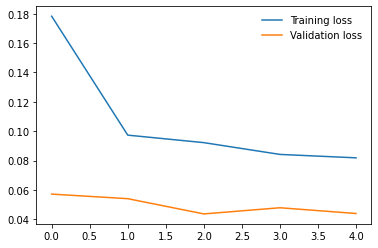

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### Subbmision

In [1]:
test_images = pd.read_csv(test_path)
test_image = test_images.loc[:,test_images.columns != "label"].values/255
test_dataset = torch.from_numpy(test_image)
#test_dataset_1 = torch.utils.data.TensorDataset(test_dataset)
new_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = False)

NameError: ignored

In [ ]:
results = []
with torch.no_grad():
    model.eval()
    for images in new_test_loader:
        test = Variable(images.view(-1,1,28,28))#.to(device)
        output = model(test)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim = 1)
        results += top_class.numpy().tolist()

In [ ]:
predictions = np.array(results).flatten()

In [ ]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("my_submissions.csv", index=False, header=True)

In [ ]:
### best on kaggle - 0.98828